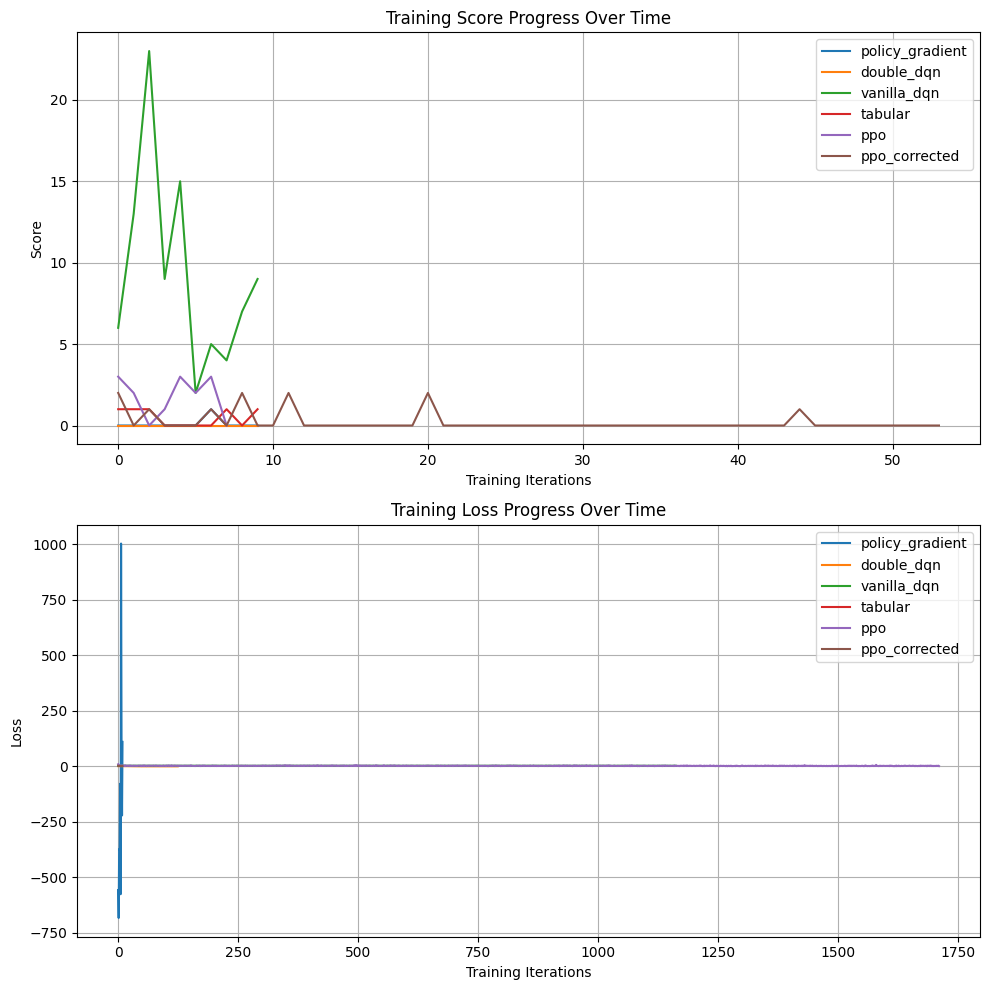

In [18]:
import os
import pickle
import matplotlib.pyplot as plt

result_file = "result.pkl"

# Check if results file exists
if not os.path.exists(result_file):
    print(f"No result file found: {result_file}")

# Load results
with open(result_file, 'rb') as f:
    results = pickle.load(f)

# Create a figure with two subplots: one for score, one for loss
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot score history for each type
for type_key, data in results.items():
    if "score" in data and isinstance(data["score"], list):
        axes[0].plot(data["score"], label=type_key)

axes[0].set_xlabel("Training Iterations")
axes[0].set_ylabel("Score")
axes[0].set_title("Training Score Progress Over Time")
axes[0].legend()
axes[0].grid(True)

# Plot loss history for each type
for type_key, data in results.items():
    if "loss" in data and isinstance(data["loss"], list):
        axes[1].plot(data["loss"], label=type_key)

axes[1].set_xlabel("Training Iterations")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training Loss Progress Over Time")
axes[1].legend()
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:

    def update(self, batch, global_step):
        # Unpack batch into separate lists
        old_states, action_indices, new_states, rewards, game_overs = zip(*batch)

        # Convert to tensors
        old_states = torch.tensor(old_states, dtype=torch.float32).to(self.device)
        action_indices = torch.tensor(action_indices, dtype=torch.long).to(self.device)
        new_states = torch.tensor(new_states, dtype=torch.float32).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        game_overs = torch.tensor(game_overs, dtype=torch.bool).to(self.device)

        with torch.no_grad():
            # Get old policy probability distribution based on state
            policy_old = self.policy_net(old_states)
            old_probs = policy_old.gather(1, action_indices.unsqueeze(1)).squeeze(1)
            old_log_probs = torch.log(old_probs + 1e-8)

        # Compute V(s) - Value of old states
        V_s = self.value_net(old_states).squeeze(1)  # shape [N]
        # Compute V(st+1) - Value of new states
        V_snew = self.value_net(new_states).squeeze(1)  # shape [N]

        advantages = torch.zeros_like(rewards).to(self.device)
        returns = torch.zeros_like(rewards).to(self.device)

        # Compute delta = r + discount * V(s') - V(s) (only if not terminal)
        delta = rewards + V_snew * self.discount * (~game_overs) - V_s

        # Compute advantages using Generalized Advantage Estimation (GAE)
        advantages[-1] = delta[-1]
        for t in reversed(range(len(rewards) - 1)):
            if game_overs[t]:
                advantages[t] = delta[t]
            else:
                advantages[t] = delta[t] + (self.discount * self.GAE * advantages[t+1])

        returns = advantages + V_s  # Returns(t) = Advantage(t) + V(s)

        # Mini-batch training: split batch into smaller batches
        for epoch in range(self.ppo_epochs):
            indices = torch.randperm(self.batch_size)

            for t in range(self.num_mini_batch):
                idx = indices[t * self.mini_batch: (t + 1) * self.mini_batch]

                # Select mini-batch samples
                mini_states = old_states[idx]
                mini_actions = action_indices[idx]
                mini_advantages = advantages[idx].detach()
                mini_returns = returns[idx].detach()
                mini_old_log_probs = old_log_probs[idx].detach()

                # Get new policy π(new)
                new_policy_probs = self.policy_net(mini_states)
                new_probs = new_policy_probs.gather(1, mini_actions.unsqueeze(1)).squeeze(1)
                new_log_probs = torch.log(new_probs + 1e-8)


                # Compute policy ratio r(θ)
                ratio = torch.exp(new_log_probs - mini_old_log_probs)

                # Compute clipped policy loss
                unclipped = ratio * mini_advantages
                clipped = torch.clamp(ratio, self.min_change, self.max_change) * mini_advantages
                policy_loss = -torch.mean(torch.min(unclipped, clipped))

                # Compute value loss
                value_loss = nn.functional.mse_loss(self.value_net(mini_states).squeeze(1), mini_returns)

                total_loss = policy_loss + value_loss

                # Backpropagation
                self.policy_optimizer.zero_grad()
                self.value_optimizer.zero_grad()
                total_loss.backward()
                self.policy_optimizer.step()
                self.value_optimizer.step()

        self.loss_history.append(total_loss.item())
        # self.writer.add_scalar("Loss/total_loss", total_loss.item(), global_step)
        # self.writer.add_scalar("Loss/policy_loss", policy_loss.item(), global_step)
        # self.writer.add_scalar("Loss/value_loss", value_loss.item(), global_step)

        

    def train(self):
        self.game.reset()

        MAX_MEMORY = 100000
        memory = deque([], maxlen=MAX_MEMORY)

        global_step = 0
        model_saved = False
        try:
            for episode in range(self.agent.max_games):
                while True:
                    #counter
                    global_step += 1

                    # get current state of self.game
                    old_state = self.agent.get_state(self.game)

                    # get action from self
                    action_index = self.action(old_state)
                    action_vector = self.agent.move[action_index]

                    # play the action in self.game
                    reward, game_over, score = self.game.play_step(action_vector)

                    # get the new state after action
                    new_state = self.agent.get_state(self.game)
                    
                    sequence = (old_state, action_index, new_state, reward, game_over)
                    # append this sequence in memory
                    memory.append(sequence)

                    # Sample batch and update, batch size = 2048
                    if len(memory) >= self.batch_size:
                        batch = random.sample(memory, self.batch_size)
                        self.update(batch, global_step)

                    if game_over:
                        self.game.reset()
                        self.agent.score_history.append(score)
                        break

                print("Game: ", episode, "score: ", score)
                
                self.writer.add_scalar("Score/episodes", score, episode)
                self.writer.add_scalar("Params/epsilon", self.epsilon, episode)

        except KeyboardInterrupt:
            self._save_model()
            self.agent.save("ppo", self.loss_history)
            model_saved = True
        finally:
            if not model_saved:
                self._save_model()
                self.agent.save("ppo", self.loss_history)
            


In [45]:
import torch

# Define sample values
rewards = torch.tensor([1.0, 0.5, -0.2, 2.0, 0.3])  # Rewards at each step
values = torch.tensor([0.8, 0.6, 0.2, 0.5, 0.1, 0.0])  # V(s) values (extra value at end for bootstrap)
dones = torch.tensor([0, 0, 0, 1, 1])  # 1 if terminal state, else 0

# Hyperparameters
gamma = 0.99  # Discount factor
lambda_gae = 0.95  # GAE lambda

# Expected Output: Advantage calculation
advantage = torch.zeros_like(rewards)
# for each timestep
for t in reversed(range(len(rewards))):
    # delta = r + gamma * 
    delta = rewards[t] + gamma * values[t + 1] * (1-dones[t]) - values[t]
    a_t = delta + gamma * lambda_gae * (1 - dones[t]) * (advantage[t+1] if t + 1 < len(rewards) else 0)
    advantage[t] = a_t

# # Compute advantages (backward pass)
# for t in reversed(range(len(rewards))):
#     delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
#     advantage[t] = delta + gamma * lambda_gae * (1 - dones[t]) * (advantage[t + 1] if t + 1 < len(rewards) else 0)

# # # Print results

print("Computed Advantages:", advantage)


Computed Advantages: tensor([2.2181, 1.5142, 1.5058, 1.5000, 0.2000])


In [52]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)
            print("advantage: ", advantage)

            values = T.tensor(values).to(self.actor.device)
            print("batches: ", batches)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               



In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import os
from torch.utils.tensorboard import SummaryWriter
from collections import deque
from torch.distributions.categorical import Categorical

class ValueNet(nn.Module):
    def __init__(self, num_states, alpha, fc1, chkpt_dir='models/ppo_value.pth'):
        super(ValueNet, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(num_states, fc1),
            nn.ReLU(),
            nn.Linear(fc1, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.checkpoint_file = chkpt_dir
    
    def forward(self, x):
        return self.critic(x)
    
    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file, weights_only=True))    

class PolicyNet(nn.Module):
    def __init__(self, num_states, num_actions, alpha, fc1, chkpt_dir='models/ppo_policy.pth'):
        super(PolicyNet, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(num_states, fc1),
            nn.ReLU(),
            nn.Linear(fc1, num_actions),
            nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.checkpoint_file = chkpt_dir

    def forward(self, x):
        dist = self.actor(x)
    
        return Categorical(dist)
    
    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file, weights_only=True))    

    
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.actions = []
        self.action_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size
    
    
    def generate_batches(self):
        n_states = len(self.states)

        # Convert lists to tensors
        states = torch.tensor(self.states, dtype=torch.float32)
        actions = torch.tensor(self.actions, dtype=torch.int64)
        action_probs = torch.tensor(self.action_probs, dtype=torch.float32)
        values = torch.tensor(self.values, dtype=torch.float32)
        rewards = torch.tensor(self.rewards, dtype=torch.float32)
        dones = torch.tensor(self.dones, dtype=torch.float32)

        # Shuffle indices
        indices = torch.randperm(n_states)  # Shuffles indices
        batches = [indices[i : i + self.batch_size] for i in range(0, n_states, self.batch_size)]

        return states[batches], actions[batches], action_probs[batches], values[batches], rewards[batches], dones[batches]
    
    def store_memory(self, state, action, action_prob, value, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.action_probs.append(action_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.action_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

class PPO:
    def __init__(self, agent, game):

        self.agent = agent
        self.game = game

        self.hidden_dim = 256
        self.num_states = 5
        self.num_actions = 3
        self.discount = 0.9
        self.value_learning_rate = 0.01
        self.theta_learning_rate = 0.001
        self.epsilon = 0.2
        self.max_change = 1 + self.epsilon
        self.min_change = 1 - self.epsilon
        self.GAE = 0.95 # lambda value between 0.9 and 1
        self.batch_size = 2048
        self.mini_batch = 256
        self.num_mini_batch = self.batch_size // self.mini_batch
        self.ppo_epochs = 6
        self.weighting_factor = 0.5
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.memory = PPOMemory(self.batch_size)

        # policy network
        self.policy_net = PolicyNet(self.num_states, self.num_actions, self.theta_learning_rate, self.hidden_dim)
        self.policy_net.to(self.device)
        
        # Value network (outputs baseline value function V(s))
        self.value_net = ValueNet(self.num_states, self.value_learning_rate,  self.hidden_dim)  # Outputs a scalar V(s)
        self.value_net.to(self.device)

        # Optimizers
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=self.theta_learning_rate)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=self.value_learning_rate)

        self.writer = SummaryWriter('runs/ppo')  # specify log dir
        self.loss_history = []
        # load model if exist
        # self._load_model()

    def train(self):

        for _ in range(self.ppo_epochs):
            states, actions, old_probs, values, rewards, dones, = self.memory.generate_batches()

            advantage = torch.zeros_like(rewards)

            # Compute Advantage Value
            for t in reversed(range(len(rewards))):
                # delta = r + discount * value[t+1] - value[t] 
                delta = rewards[t] + self.discount * (values[t + 1] if t + 1 < len(rewards) else 0) * (1-dones[t]) - values[t]
                # a = delta + self.discount * gae_lambda * a[t+1]
                a_t = delta + self.discount * self.GAE * (1 - dones[t]) * (advantage[t+1] if t + 1 < len(rewards) else 0)
                advantage[t] = a_t
                
            for i in range(len(states)):
                # policy of new states
                action_dist = self.policy_net(states[i])  # Returns a Categorical distribution
                
                # ✅ Ensure actions[i] is a long tensor and is within range
                action = actions[i].long().clamp(0, self.num_actions - 1)

                new_probs = action_dist.log_prob(action)  # Get log probability
                new_value = self.value_net(states[i]).squeeze(0)  # Get value estimate

                ratio = new_probs.exp() / old_probs[i].exp()  # Compute PPO ratio


                unclipped = ratio * advantage[i]

                clipped = torch.clamp(ratio, self.min_change, self.max_change) * advantage[i]

                policy_loss = -torch.min(unclipped, clipped).mean()

                returns = advantage[i] + values[i]
                value_loss = (returns - new_value) ** 2
                value_loss = value_loss.mean()

                total_loss = policy_loss + self.weighting_factor * value_loss

                self.policy_net.optimizer.zero_grad()
                self.value_net.optimizer.zero_grad()

                total_loss.backward()

                self.policy_net.optimizer.step()
                self.value_net.optimizer.step()

        self.memory.clear_memory()


    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def _load_model(self):
        value_checkpoint_path = 'models/ppo_value_net.pth'
        policy_checkpoint_path = 'models/ppo_policy_net.pth'
        if os.path.exists(value_checkpoint_path) and os.path.exists(policy_checkpoint_path):
            self.policy_net.load_state_dict(torch.load(policy_checkpoint_path, map_location=self.device, weights_only=True))
            self.value_net.load_state_dict(torch.load(value_checkpoint_path, map_location=self.device, weights_only=True))
            print(f"Loaded existing weights from {policy_checkpoint_path} and {value_checkpoint_path}.")
        else:
            print("No existing checkpoint found. Starting fresh.")
    
    def action(self, state):
        """Chooses an action using the current policy and value network."""
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)

        with torch.no_grad():  # No gradient needed during inference
            action_dist = self.policy_net(state_tensor)  # Get categorical action distribution
            value = self.value_net(state_tensor)  # Get value estimate
            action = action_dist.sample()  # Sample action

            log_prob = action_dist.log_prob(action).item()  # Log probability of action
            action = action.item()  # Convert action to Python scalar
            value = value.squeeze(0).item()  # Convert value to scalar

        return action, log_prob, value


    def _save_model(self):
        print("PPO Model saved")
        torch.save(self.policy_net.state_dict(), 'models/ppo_policy_net.pth')
        torch.save(self.value_net.state_dict(), 'models/ppo_value_net.pth')

In [81]:
import numpy as np
import torch as T

# Set random seeds for reproducibility
np.random.seed(42)
T.manual_seed(42)

# Fake Environment for Testing
class FakeEnv:
    def __init__(self, state_dim, n_actions):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.state = np.random.rand(state_dim)
    
    def reset(self):
        self.state = np.random.rand(self.state_dim)
        return self.state

    def step(self, action):
        reward = np.random.randn()  # Random reward
        done = np.random.rand() < 0.1  # 10% chance of episode ending
        next_state = np.random.rand(self.state_dim)
        return next_state, reward, done

# Initialize PPO Agent & Fake Environment
state_dim = 5  # Example state space size
n_actions = 3  # Example number of actions
ppo = PPO(agent=None, game=None)  # We don't use agent/game in the test
env = FakeEnv(state_dim, n_actions)

num_steps = 10  # Number of steps per episode

print("\n===== Running PPO Test Case =====\n")

# Run a fake episode and store transitions
state = env.reset()
for step in range(num_steps):
    action = ppo.action(state)
    next_state, reward, done = env.step(action)

    print(f"Step {step+1}:")
    print(f" - State: {state}")
    print(f" - Action Taken: {action}")
    print(f" - Reward: {reward}")
    print(f" - Done: {done}\n")

    ppo.remember(state, action, T.tensor(1.0), T.tensor(1.0), reward, done)  # Dummy prob & value
    state = next_state
    if done:
        break

print("\n===== Memory Stored =====\n")
print(f"States Stored: {len(ppo.memory.states)}")
print(f"Rewards Stored: {len(ppo.memory.rewards)}")
print(f"Dones Stored: {len(ppo.memory.dones)}\n")

# Run PPO Training Step
print("\n===== PPO Training Begins =====\n")
ppo.train()
print("\n===== PPO Training Complete =====\n")



===== Running PPO Test Case =====

Step 1:
 - State: [0.15599452 0.05808361 0.86617615 0.60111501 0.70807258]
 - Action Taken: (0, -0.9500914216041565, 0.19830161333084106)
 - Reward: -0.4694743859349521
 - Done: False

Step 2:
 - State: [0.18340451 0.30424224 0.52475643 0.43194502 0.29122914]
 - Action Taken: (0, -0.9401532411575317, 0.21110039949417114)
 - Reward: 0.5425600435859647
 - Done: False

Step 3:
 - State: [0.13949386 0.29214465 0.36636184 0.45606998 0.78517596]
 - Action Taken: (0, -0.9653173685073853, 0.1433621644973755)
 - Reward: 0.06752820468792384
 - Done: False

Step 4:
 - State: [0.04645041 0.60754485 0.17052412 0.06505159 0.94888554]
 - Action Taken: (1, -1.2094203233718872, 0.11820320785045624)
 - Reward: -1.4247481862134568
 - Done: False

Step 5:
 - State: [0.80839735 0.30461377 0.09767211 0.68423303 0.44015249]
 - Action Taken: (1, -1.2034481763839722, 0.18208450078964233)
 - Reward: -0.013497224737933921
 - Done: True


===== Memory Stored =====

States Store

C:\Users\kyu\AppData\Local\Temp\ipykernel_19524\1471236656.py:74: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  actions = torch.tensor(self.actions, dtype=torch.int64)


In [57]:
import numpy as np
import torch as T

# Set up a test case
np.random.seed(42)
T.manual_seed(42)

# Define a fake environment
class FakeEnv:
    def __init__(self, state_dim, n_actions):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.state = np.random.rand(state_dim)
    
    def reset(self):
        self.state = np.random.rand(self.state_dim)
        return self.state

    def step(self, action):
        reward = np.random.randn()  # Random reward
        done = np.random.rand() < 0.1  # 10% chance of episode ending
        next_state = np.random.rand(self.state_dim)
        return next_state, reward, done

# Initialize agent and fake environment
state_dim = 5  # Example state size
n_actions = 3  # Example action space
agent = Agent(n_actions=n_actions, input_dims=[state_dim])

env = FakeEnv(state_dim, n_actions)
num_steps = 10  # Number of steps per episode

print("\n===== Running PPO Test Case =====\n")

# Run one fake episode
state = env.reset()
for step in range(num_steps):
    action, prob, value = agent.choose_action(state)
    next_state, reward, done = env.step(action)

    print(f"Step {step+1}:")
    print(f" - State: {state}")
    print(f" - Action Taken: {action}")
    print(f" - Log Prob: {prob}")
    print(f" - Critic Value: {value}")
    print(f" - Reward: {reward}")
    print(f" - Done: {done}\n")

    agent.remember(state, action, prob, value, reward, done)
    state = next_state
    if done:
        break

print("\n===== Memory Stored =====\n")
print(f"States Stored: {len(agent.memory.states)}")
print(f"Rewards Stored: {len(agent.memory.rewards)}")
print(f"Dones Stored: {len(agent.memory.dones)}\n")

# Perform PPO learning
print("\n===== PPO Learning Begins =====\n")
agent.learn()
print("\n===== PPO Learning Complete =====\n")


===== Running PPO Test Case =====

Step 1:
 - State: [0.15599452 0.05808361 0.86617615 0.60111501 0.70807258]
 - Action Taken: 1
 - Log Prob: -1.081394076347351
 - Critic Value: -0.012536033987998962
 - Reward: -0.4694743859349521
 - Done: False

Step 2:
 - State: [0.18340451 0.30424224 0.52475643 0.43194502 0.29122914]
 - Action Taken: 0
 - Log Prob: -1.029179573059082
 - Critic Value: 0.019290363416075706
 - Reward: 0.5425600435859647
 - Done: False

Step 3:
 - State: [0.13949386 0.29214465 0.36636184 0.45606998 0.78517596]
 - Action Taken: 1
 - Log Prob: -1.0772666931152344
 - Critic Value: 0.016075171530246735
 - Reward: 0.06752820468792384
 - Done: False

Step 4:
 - State: [0.04645041 0.60754485 0.17052412 0.06505159 0.94888554]
 - Action Taken: 1
 - Log Prob: -1.0801746845245361
 - Critic Value: -4.734843969345093e-05
 - Reward: -1.4247481862134568
 - Done: False

Step 5:
 - State: [0.80839735 0.30461377 0.09767211 0.68423303 0.44015249]
 - Action Taken: 0
 - Log Prob: -1.048751